# FIABILITE

## Jérôme PAYEN, Valentin ROBERT, Vinh-Hoa TU

### DÉTERMINATION DE LA HAUTEUR DE LA DIGUE À PARTIR DES RELEVÉS DE MESURE HISTORIQUES

Nous avons accès aux données historiques de 1849 à 1997 seulement. Les données sont le débit d'eau Q maximum à l'année associé à la hauteur de l'eau H. Nous voulons à partir de ces données proposer une hauteur $h_d$ de la digue de façon à minimiser le risque d'inondation.

## Import des données et des librairies

In [40]:
# Import des librairies
library(evd)
library(readxl)
library(ggplot2)
library(triangle)
library(nortest)
library(evd)
library(MASS)  
library(fitdistrplus) 
library(car)  
library(EWGoF)
library(lmomco)


Attachement du package : 'lmomco'


L'objet suivant est masqu'e depuis 'package:evd':

    pp




## Modèle historique

In [41]:
data <- read_excel("./data.xlsx")
colnames(data) <- c("Annee", "Debit", "Hauteur")
data_clean <- na.omit(data)

### Recherche de la loi des données historiques

#### Adéquation loi de Weibull

In [42]:
WEDF.test(data_clean$Hauteur, type = "AD")
WEDF.test(data_clean$Hauteur, type = "KS")
WEDF.test(data_clean$Hauteur, type = "CM")


	Test of Anderson Darling for the Weibull distribution using the MLEs

data:  data_clean$Hauteur
S = 0.31005, p-value = 0.59
sample estimates:
     eta     beta 
4.339365 3.366444 



	Test of Kolmogorov-Smirnoff for the Weibull distribution using the
	MLEs

data:  data_clean$Hauteur
S = 0.70714, p-value = 0.23
sample estimates:
     eta     beta 
4.339365 3.366444 



	Test of Cramer von Mises for the Weibull distribution using the MLEs

data:  data_clean$Hauteur
S = 0.0482, p-value = 0.495
sample estimates:
     eta     beta 
4.339365 3.366444 


In [43]:
eta_MLE <- MLEst(data_clean$Hauteur)$eta
beta_MLE <- MLEst(data_clean$Hauteur)$beta

In [44]:
beta_MLE

[1] 3.366444

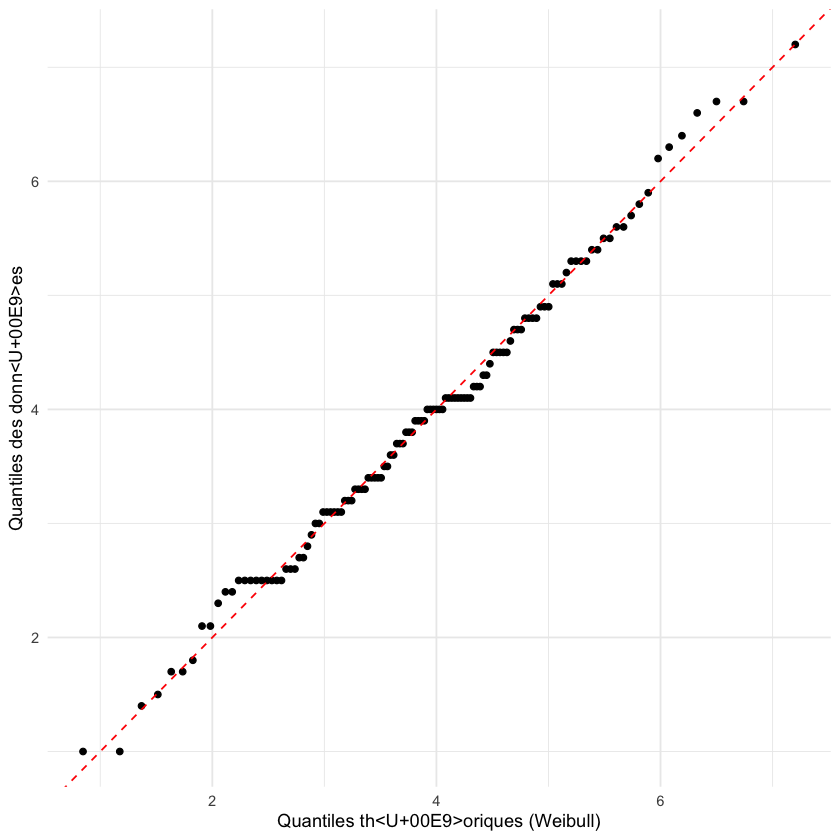

In [45]:
# Générer les quantiles théoriques
qq_data <- data.frame(
  Theorique = qweibull(ppoints(length(data_clean$Hauteur)), shape = beta_MLE, scale = eta_MLE),
  Observer = sort(data_clean$Hauteur)
)


# QQ-plot pour la loi de Weibull
ggplot(qq_data, aes(x = Theorique, y = Observer)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(x = "Quantiles théoriques (Weibull)", y = "Quantiles des données") +
  theme_minimal()

In [46]:
q_W <- qweibull(0.9999, shape = beta_MLE, scale = eta_MLE)
h_d_W <- q_W - 4.5 
h_d_W

[1] 3.891965

#### Adéquation loi de Gumbel

Warning message in fitdist(data_clean$Hauteur, "gumbel", start = list(loc = mean(data_clean$Hauteur), :
"The dgumbel function should return a vector of with NaN values when input has inconsistent parameters and not raise an error"
Warning message in fitdist(data_clean$Hauteur, "gumbel", start = list(loc = mean(data_clean$Hauteur), :
"The pgumbel function should return a vector of with NaN values when input has inconsistent parameters and not raise an error"


loc    scale 
3.271673 1.193892

Warning message in ks.test.default(data_clean$Hauteur, "pgumbel", loc = fit_gumbel$estimate["loc"], :
"ties should not be present for the one-sample Kolmogorov-Smirnov test"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_clean$Hauteur
D = 0.082341, p-value = 0.3748
alternative hypothesis: two-sided



Attachement du package : 'goftest'


Les objets suivants sont masqu'es depuis 'package:nortest':

    ad.test, cvm.test





	Anderson-Darling test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
An = 1.0781, p-value = 0.3186



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
omega2 = 0.15765, p-value = 0.3675


loc 
14.26777

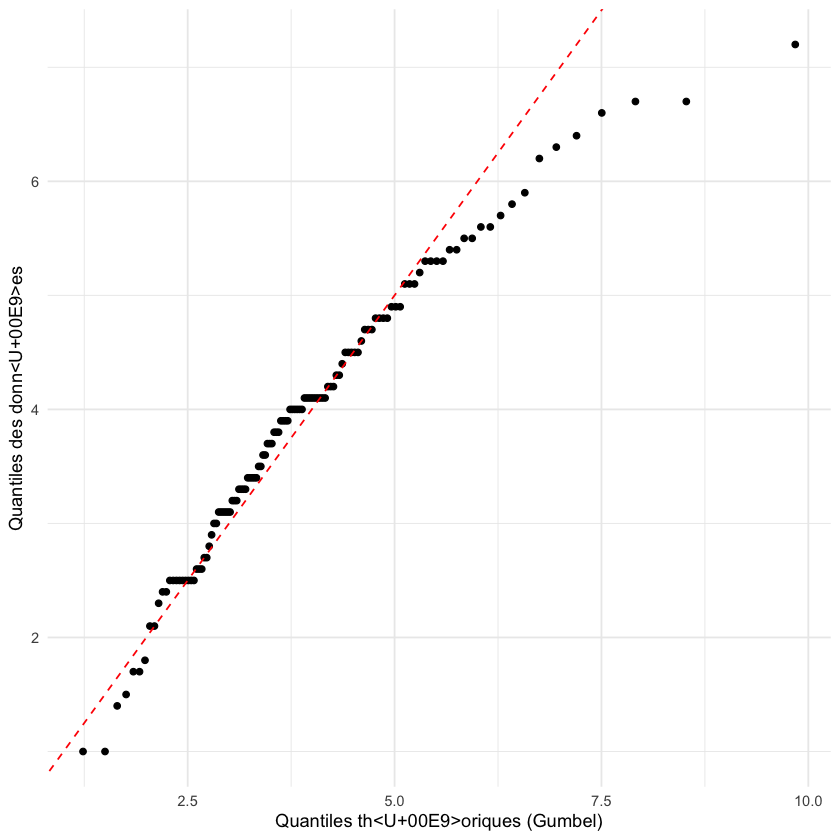

In [47]:
library(fitdistrplus)
library(evd)  # Package pour la loi de Gumbel

# Ajustement de la loi de Gumbel aux données
fit_gumbel <- fitdist(data_clean$Hauteur, "gumbel", start = list(loc = mean(data_clean$Hauteur), scale = sd(data_clean$Hauteur)))

# Affichage des paramètres estimés
fit_gumbel$estimate

ks.test(data_clean$Hauteur, "pgumbel", 
        loc = fit_gumbel$estimate["loc"], 
        scale = fit_gumbel$estimate["scale"])

library(goftest)

# Transformation en loi uniforme (Probability Integral Transform)
u <- pgumbel(data_clean$Hauteur, loc = fit_gumbel$estimate["loc"], scale = fit_gumbel$estimate["scale"])

# Test d'Anderson-Darling
ad.test(u, null = "punif")

library(goftest)

# Test de Cramer-von Mises
cvm.test(u, null = "punif")

qq_data <- data.frame(
  Theorique = qgumbel(ppoints(length(data_clean$Hauteur)), loc = fit_gumbel$estimate["loc"], scale = fit_gumbel$estimate["scale"]),
  Observer = sort(data_clean$Hauteur)
)

ggplot(qq_data, aes(x = Theorique, y = Observer)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(x = "Quantiles théoriques (Gumbel)", y = "Quantiles des données") +
  theme_minimal()

qgumbel(0.9999, loc = fit_gumbel$estimate["loc"], scale = fit_gumbel$estimate["scale"])

In [48]:
qgumbel(0.9999, loc = fit_gumbel$estimate["loc"], scale = fit_gumbel$estimate["scale"])

loc 
14.26777

#### Adéquation loi de Fréchet

Warning message in checkparamlist(arg_startfix$start.arg, arg_startfix$fix.arg, :
"Some parameter names have no starting/fixed value but have a default value: loc."
Warning message in fitdist(data_clean$Hauteur, "frechet", start = list(shape = 1, :
"The dfrechet function should return a vector of with NaN values when input has inconsistent parameters and not raise an error"
Warning message in fitdist(data_clean$Hauteur, "frechet", start = list(shape = 1, :
"The pfrechet function should return a vector of with NaN values when input has inconsistent parameters and not raise an error"


shape    scale 
2.202531 3.004841

Warning message in ks.test.default(data_clean$Hauteur, "pfrechet", shape = fit_frechet$estimate["shape"], :
"ties should not be present for the one-sample Kolmogorov-Smirnov test"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_clean$Hauteur
D = 0.14922, p-value = 0.008359
alternative hypothesis: two-sided



	Anderson-Darling test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
An = 6.2001, p-value = 0.0007862



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
omega2 = 0.97837, p-value = 0.002697


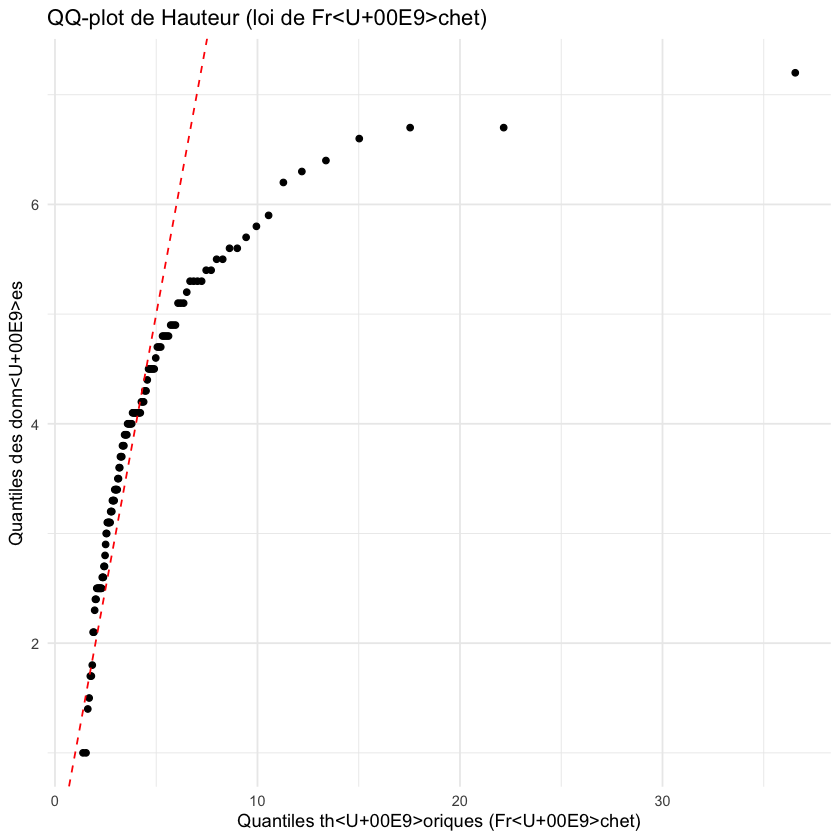

In [49]:
# Ajustement d'une loi de Fréchet aux données
fit_frechet <- fitdist(data_clean$Hauteur, "frechet", 
                       start = list(shape = 1, scale = mean(data_clean$Hauteur)))

# Affichage des paramètres ajustés
fit_frechet$estimate

ks.test(data_clean$Hauteur, "pfrechet", 
        shape = fit_frechet$estimate["shape"], 
        scale = fit_frechet$estimate["scale"])

# Transformation en loi uniforme
u <- pfrechet(data_clean$Hauteur, shape = fit_frechet$estimate["shape"], scale = fit_frechet$estimate["scale"])

# Test d'Anderson-Darling
ad.test(u, null = "punif")

# Test de Cramer-von Mises
cvm.test(u, null = "punif")

qq_data <- data.frame(
  Theorique = qfrechet(ppoints(length(data_clean$Hauteur)), 
                       shape = fit_frechet$estimate["shape"], 
                       scale = fit_frechet$estimate["scale"]),
  Observer = sort(data_clean$Hauteur)
)

ggplot(qq_data, aes(x = Theorique, y = Observer)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "QQ-plot de Hauteur (loi de Fréchet)", 
       x = "Quantiles théoriques (Fréchet)", 
       y = "Quantiles des données") +
  theme_minimal()

#### Adéquation loi log-normale

meanlog     sdlog 
1.2992744 0.3682806

Warning message in ks.test.default(data_clean$Hauteur, "plnorm", meanlog = fit_lognorm$estimate["meanlog"], :
"ties should not be present for the one-sample Kolmogorov-Smirnov test"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_clean$Hauteur
D = 0.094983, p-value = 0.2171
alternative hypothesis: two-sided



	Anderson-Darling test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
An = 1.3484, p-value = 0.2172



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
omega2 = 0.20832, p-value = 0.2521


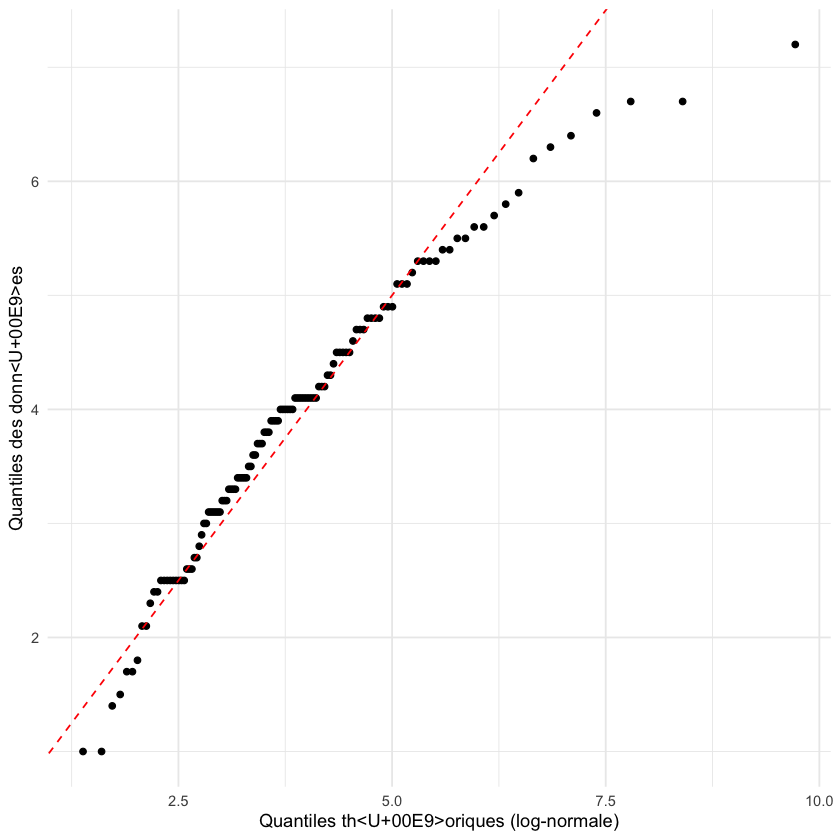

In [50]:
# Ajustement de la loi log-normale aux données
fit_lognorm <- fitdist(data_clean$Hauteur, "lnorm")

# Affichage des paramètres estimés
fit_lognorm$estimate

ks.test(data_clean$Hauteur, "plnorm", 
        meanlog = fit_lognorm$estimate["meanlog"], 
        sdlog = fit_lognorm$estimate["sdlog"])

# Transformation en loi uniforme
u <- plnorm(data_clean$Hauteur, meanlog = fit_lognorm$estimate["meanlog"], 
                               sdlog = fit_lognorm$estimate["sdlog"])

# Test d'Anderson-Darling
ad.test(u, null = "punif")

# Test de Cramer-von Mises
cvm.test(u, null = "punif")

qq_data <- data.frame(
  Theorique = qlnorm(ppoints(length(data_clean$Hauteur)), 
                     meanlog = fit_lognorm$estimate["meanlog"], 
                     sdlog = fit_lognorm$estimate["sdlog"]),
  Observer = sort(data_clean$Hauteur)
)

ggplot(qq_data, aes(x = Theorique, y = Observer)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs( x = "Quantiles théoriques (log-normale)", y = "Quantiles des données") +
  theme_minimal()

In [51]:
qlnorm(0.9999, meanlog = fit_lognorm$estimate["meanlog"], sdlog = fit_lognorm$estimate["sdlog"])

[1] 14.42433

#### Adéquation loi de Pearson 3

[1] 0.2087973

[1] 1.280944

[1] 3.896748

Warning message in ks.test.default(data_clean$Hauteur, function(x) cdfpe3(x, params_pearson3)):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_clean$Hauteur
D = 0.049665, p-value = 0.922
alternative hypothesis: two-sided



	Anderson-Darling test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
An = 0.23959, p-value = 0.9756



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  u
omega2 = 0.037733, p-value = 0.9451


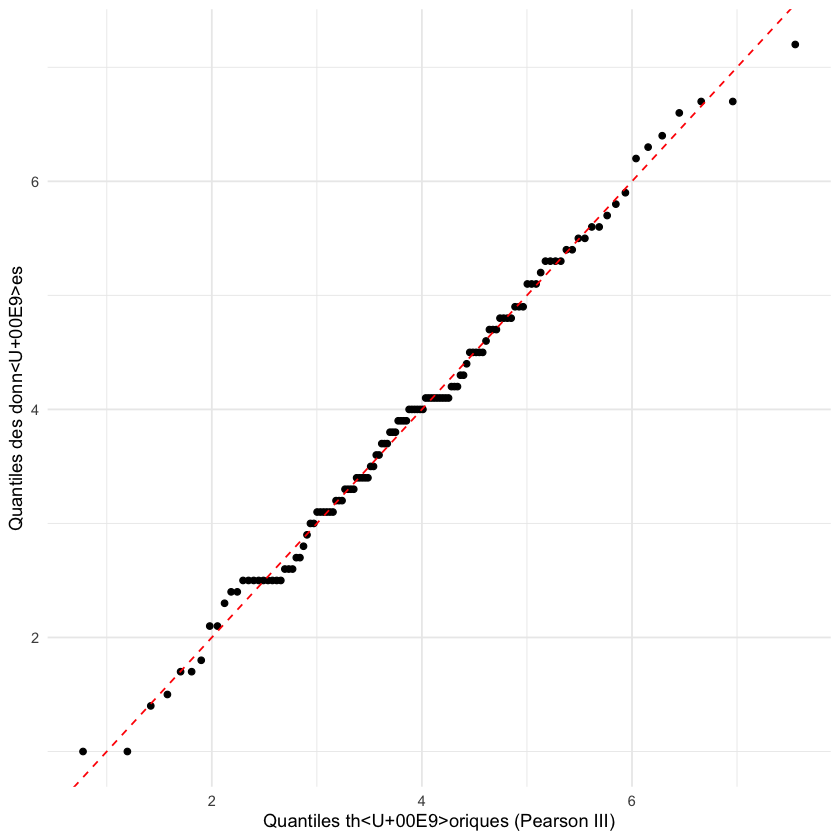

In [52]:
lmoments <- lmom.ub(data_clean$Hauteur)  # Moments L
params_pearson3 <- parpe3(lmoments)  # Ajustement à Pearson III

# Extraction des paramètres
shape_pearson3 <- params_pearson3$para[[3]]  # Skewness (asymétrie)
scale_pearson3 <- params_pearson3$para[[2]]  # Échelle
location_pearson3 <- params_pearson3$para[[1]]  # Position

# Affichage des paramètres estimés
shape_pearson3
scale_pearson3
location_pearson3

ks.test(data_clean$Hauteur, function(x) cdfpe3(x, params_pearson3))

# Transformation en loi uniforme
u <- cdfpe3(data_clean$Hauteur, params_pearson3)

# Test d'Anderson-Darling
ad.test(u, null = "punif")

# Test de Cramer-von Mises
cvm.test(u, null = "punif")

qq_data <- data.frame(
  Theorique = quape3(ppoints(length(data_clean$Hauteur)), params_pearson3),
  Observer = sort(data_clean$Hauteur)
)

ggplot(qq_data, aes(x = Theorique, y = Observer)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs( x = "Quantiles théoriques (Pearson III)", y = "Quantiles des données") +
  theme_minimal()

In [53]:
# Quantile d'ordre 0.9999 pour la loi de Pearson III
quantile_0.9999 <- quape3(0.9999, params_pearson3)

# Affichage du quantile
print(quantile_0.9999)


[1] 9.241304


In [54]:
q_P <- quape3(0.9999, params_pearson3)
h_d_P <- q_P - 4.5
h_d_P

[1] 4.741304

### Bootstrap

#### Param Weibull

In [55]:
# Initialisation pour le bootstrap
set.seed(123)  # Pour reproductibilité
n_boot <- 1000000  # Nombre de répétitions Monte Carlo
eta_boot <- numeric(n_boot)
beta_boot <- numeric(n_boot)

Zb <- 55.5
Zv <- rtriangle(n_boot, a=49, b=51, c=50)
surverse_W <- numeric(n_boot)

# Simulation bootstrap
for (i in 1:n_boot) {
    # Générer un échantillon bootstrap de même taille
    sample_boot <- rweibull(length(data_clean$Hauteur), shape = beta_MLE, scale = eta_MLE)
    
    # Stocker les nouveaux paramètres
    MLE_boot <- MLEst(sample_boot)
    eta_boot[i] <- MLE_boot$eta
    beta_boot[i] <- MLE_boot$beta

    # Sample bootstrap
    sample_boot <- rweibull(1, shape = beta_boot[i], scale = eta_boot[i])
    surverse_W[i] <- sample_boot + Zv[i] - Zb
}

# Estimation de quantiles pour l'incertitude
quantile_eta <- quantile(eta_boot, c(0.025, 0.5, 0.975))  # IC 95%
quantile_beta <- quantile(beta_boot, c(0.025, 0.5, 0.975))

print(quantile_eta)
print(quantile_beta)

    2.5%      50%    97.5% 
4.097457 4.337215 4.576247 
    2.5%      50%    97.5% 
2.965582 3.391961 3.915659 


In [56]:
quantiles_9999_W <- sapply(1:n_boot, function(i) {
    qweibull(0.9999, shape = beta_boot[i], scale = eta_boot[i])
})

# Affichage du quantile médian et intervalle de confiance
quantile(quantiles_9999_W, 0.5)

50% 
8.349543

In [57]:
quantile(surverse_W, 0.9999)

99.99% 
3.312122

#### Param Pearson

In [58]:
# Initialisation pour le bootstrap
set.seed(123)  # Pour reproductibilité
n_boot <- 1000000  # Nombre de répétitions Monte Carlo
shape_boot <- numeric(n_boot)
scale_boot <- numeric(n_boot)
location_boot <- numeric(n_boot)
quantiles_9999_P <- numeric(n_boot)
surverse_P <- numeric(n_boot)

# Simulation bootstrap
for (i in 1:n_boot) {
    # Générer un échantillon bootstrap à partir de la loi de Pearson III ajustée
    sample_boot <- rlmomco(length(data_clean$Hauteur), params_pearson3)
    
    # Estimation des paramètres sur l'échantillon bootstrap
    lmom_boot <- lmom.ub(sample_boot)
    params_boot <- parpe3(lmom_boot)
    
    # Stocker les nouveaux paramètres
    shape_boot[i] <- params_boot$para[3]  # Skewness (asymétrie)
    scale_boot[i] <- params_boot$para[2]  # Échelle
    location_boot[i] <- params_boot$para[1]  # Position

    quantiles_9999_P[i] <- quape3(0.9999, params_boot)

    # Sample bootstrap
    sample_boot <- rlmomco(1, params_boot)
    surverse_P[i] <- sample_boot + Zv[i] - Zb
}

# Estimation des quantiles pour l'incertitude (IC 95%)
quantile_shape <- quantile(shape_boot, c(0.025, 0.5, 0.975))  
quantile_scale <- quantile(scale_boot, c(0.025, 0.5, 0.975))
quantile_location <- quantile(location_boot, c(0.025, 0.5, 0.975))

# Affichage des résultats
print(quantile_shape)
print(quantile_scale)
print(quantile_location)


      2.5%        50%      97.5% 
-0.2706285  0.2080635  0.6802289 
    2.5%      50%    97.5% 
1.121086 1.282336 1.451606 
    2.5%      50%    97.5% 
3.671272 3.896458 4.124090 


In [59]:
quantile(quantiles_9999_P, 0.9999)

99.99% 
12.72085

In [60]:
quantile(surverse_P, 0.9999)

99.99% 
4.39745

In [61]:
# Initialisation pour le bootstrap
set.seed(123)  # Pour reproductibilité
n_boot <- 1000000  # Nombre de répétitions Monte Carlo
Zb <- 55.5
Zv <- rtriangle(n_boot, a=49, b=51, c=50)

surverse <- numeric(n_boot)

# Simulation bootstrap
for (i in 1:n_boot) {
    # Générer un échantillon bootstrap de même taille
    sample_boot <- rweibull(length(data_clean$Hauteur), shape = beta_MLE, scale = eta_MLE)
    
    # Stocker les nouveaux paramètres
    MLE_boot <- MLEst(sample_boot)
    eta_boot <- MLE_boot$eta
    beta_boot <- MLE_boot$beta

    # Sample bootstrap
    sample_boot <- rweibull(1, shape = beta_boot, scale = eta_boot)
    surverse[i] <- sample_boot + Zv[i] - Zb
}

In [62]:
q <- quantile(surverse_W, c(0.95, 0.97, 0.99, 0.999, 0.9999, 0.99999, 0.999999))

cat("Quantile 95%     :", q[1], "\n")
cat("Quantile 97%     :", q[2], "\n")
cat("Quantile 99%     :", q[3], "\n")
cat("Quantile 99.9%   :", q[4], "\n")
cat("Quantile 99.99%  :", q[5], "\n")
cat("Quantile 99.999% :", q[6], "\n")
cat("Quantile 99.9999%:", q[7], "\n")


Quantile 95%     : 0.6114461 
Quantile 97%     : 0.9199388 
Quantile 99%     : 1.496247 
Quantile 99.9%   : 2.487146 
Quantile 99.99%  : 3.312122 
Quantile 99.999% : 3.972615 
Quantile 99.9999%: 4.498084 


### Prédiction par la modèle linéaire généralisé et la méthode de Monté Carlo

#### Représentations graphiques

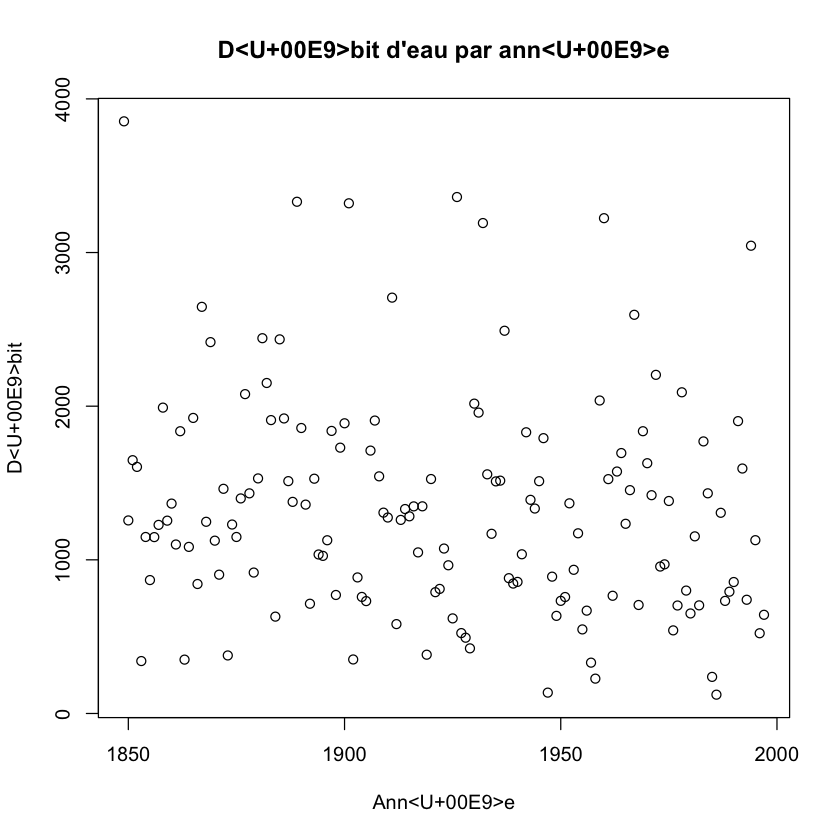

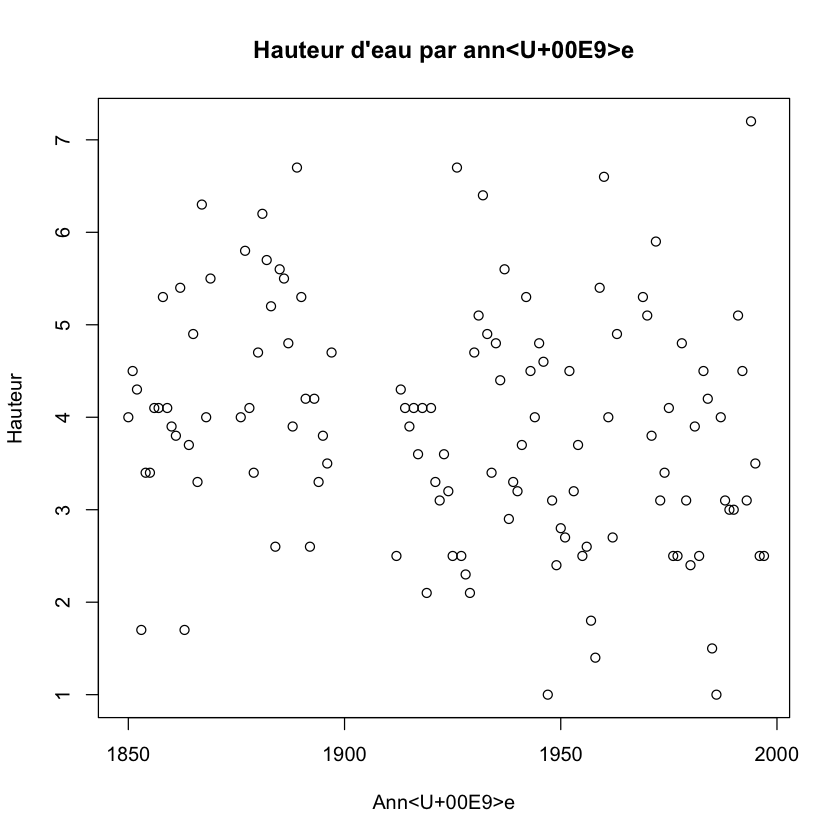

In [63]:
plot(x=data$Annee, y=data$Debit, xlab="Année", ylab="Débit", main="Débit d'eau par année" )
plot(x=data$Annee,y=data$Hauteur, xlab="Année", ylab="Hauteur", main="Hauteur d'eau par année" )

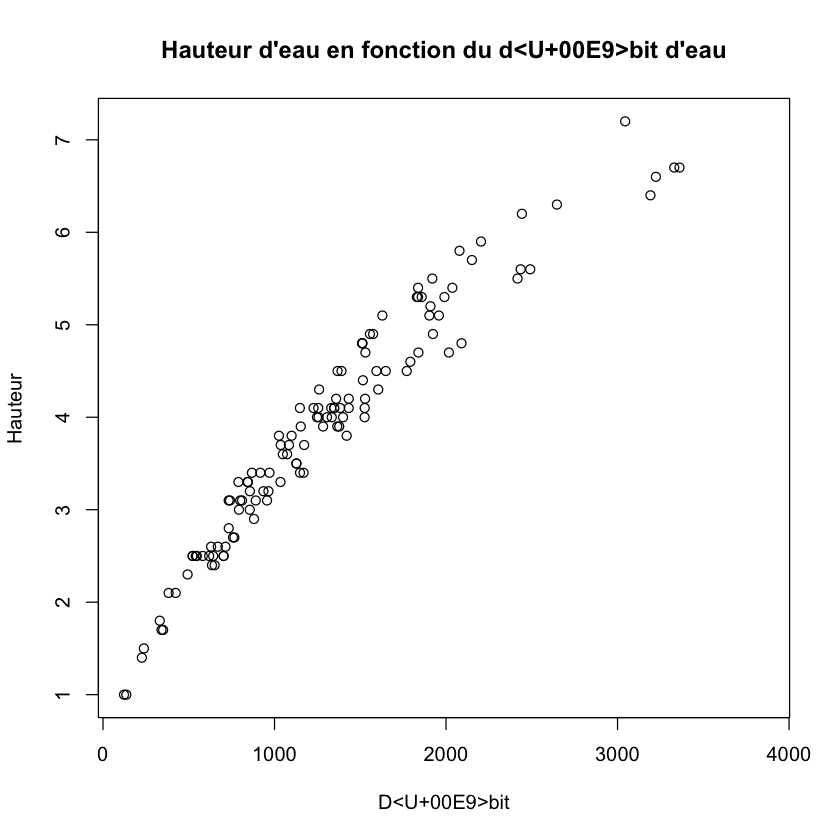

In [64]:
plot(x = data$Debit, y = data$Hauteur, xlab="Débit", ylab="Hauteur", main="Hauteur d'eau en fonction du débit d'eau")

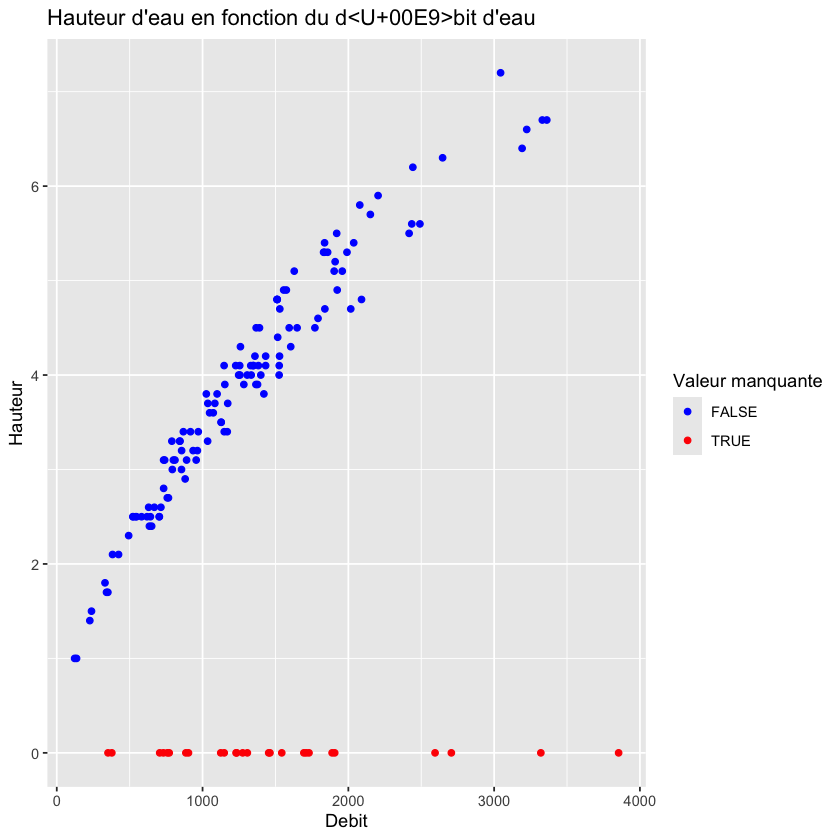

In [65]:
data[is.na(data)] <- 0
ggplot(data = data, aes(x = Debit, y = Hauteur)) +
  geom_point(aes(color = (Hauteur == 0))) + 
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "blue")) +
  labs(color = "Valeur manquante", title="Hauteur d'eau en fonction du débit d'eau") 
  

#### Modélisation de la relation Debit-Hauteur

In [66]:
# Modélisation par régréssion linéaire avec transformation de la variables Debit
model_glm <- lm(Hauteur ~ sqrt(Debit), data=data_clean)  
summary(model_glm)


Call:
lm(formula = Hauteur ~ sqrt(Debit), data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52265 -0.21498 -0.01522  0.17077  0.63911 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.664844   0.086249  -7.708 3.96e-12 ***
sqrt(Debit)  0.130958   0.002389  54.815  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2514 on 121 degrees of freedom
Multiple R-squared:  0.9613,	Adjusted R-squared:  0.961 
F-statistic:  3005 on 1 and 121 DF,  p-value: < 2.2e-16


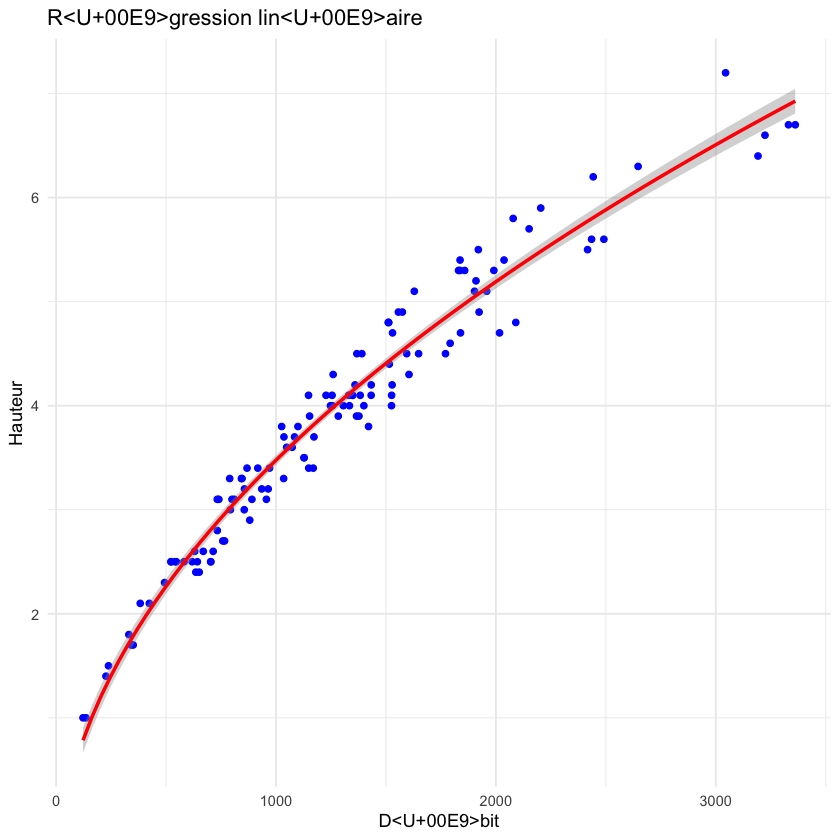

In [67]:
# Tracer les données et ajouter la courbe de régression 
ggplot(data_clean, aes(x = Debit, y = Hauteur)) +
  geom_point(color = "blue") +  # Affichage des points
  geom_smooth(method = "lm", formula = y ~ sqrt(x), color = "red", level = 0.95) +  # Courbe de régression avec intervalle de confiance à 95%
  labs(title = "Régression linéaire",
       x = "Débit",
       y = "Hauteur") +
  theme_minimal()

#### Gestion des valeurs manquantes

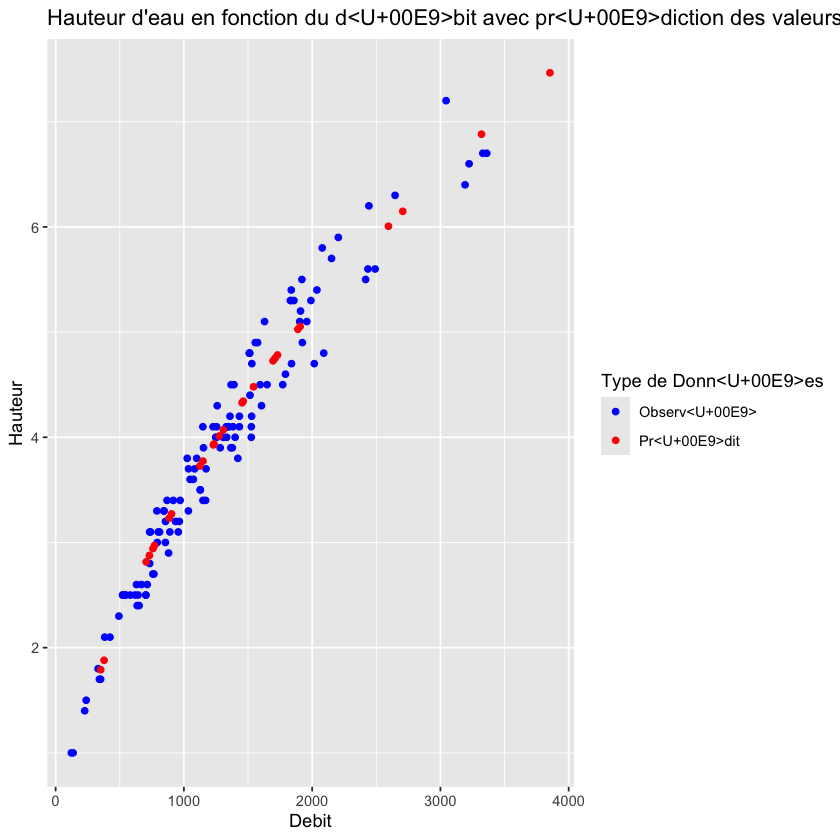

In [68]:
#projection des prédictions sur la courbe de régression
data_na <- data[data$Hauteur == 0,]
predictions <- predict(model_glm,data_na[, "Debit"],interval='conf',level=0.999999)
pred <- cbind(predictions, data_na[, -3])

# Ajouter une colonne "Source" pour identifier chaque dataframe
data_clean$Source <- "Observé"
pred$Source <- "Prédit"

# Renommer la colonne "fit" de pred pour correspondre à "Hauteur"
colnames(pred)[colnames(pred) == "fit"] <- "Hauteur"

# Fusionner les deux dataframes
df_combined <- rbind(data_clean, pred[,c("Annee", "Debit", "Hauteur", "Source")])

# Tracer avec ggplot
ggplot(df_combined, aes(x = Debit, y = Hauteur, color = Source)) +
  geom_point() +
  scale_color_manual(values = c("Observé" = "blue", "Prédit" = "red")) +
  labs(color = "Type de Données", title="Hauteur d'eau en fonction du débit avec prédiction des valeurs manquantes")



In [69]:
data_fill <- data
rank <- 1
for (i in 1:nrow(data_fill)){
    if (data_fill[i, "Hauteur"] == 0){
        data_fill[i, "Hauteur"] <- pred[rank, "Hauteur"]
        rank <- rank+1
    }
}

#### Trois modèles d'estimations de hauteur de digue avec les données historiques

Le deux premiers modèles consistent à modéliser la relation entre la hauteur et le débit d'eau.  
Puis nous modélisons les résidus de la régression et enfin nous prenons en compte l'incertitude de la côte en aval Zv.  
Le troisième modèle correspond à l'utilisation de simulations Monte-Carlo. Nous pouvons modéliser la hauteur de surverse avec des variables aléatoires et donc nous allons simuler plusieurs valeurs de surverse et calculer le quantile empirique à 99.99%.

Le premier modèle sera très conservateur. Pour la loi de Gumbel et la la loi des résidus, nous prendrons un quantile très élevé de niveau 0.9999 et nous prendrons le max de Zv qui suit une loi triangulaire.  
Le deuxième modèle est plus modéré et nous ne prendrons pas en compte les résidus de la modélisation et prendrons la moyenne de Zv.  
Le dernier modèle est plus robuste car il ne pose pas la question de savoir si le cumul des incertitudes est additif ou multiplicatif.

#### Modélisation de la relation entre la hauteur et le débit d'eau


	Shapiro-Wilk normality test

data:  data$Debit
W = 0.93877, p-value = 4.564e-06



	Anderson-Darling normality test

data:  data$Debit
A = 2.0762, p-value = 2.648e-05


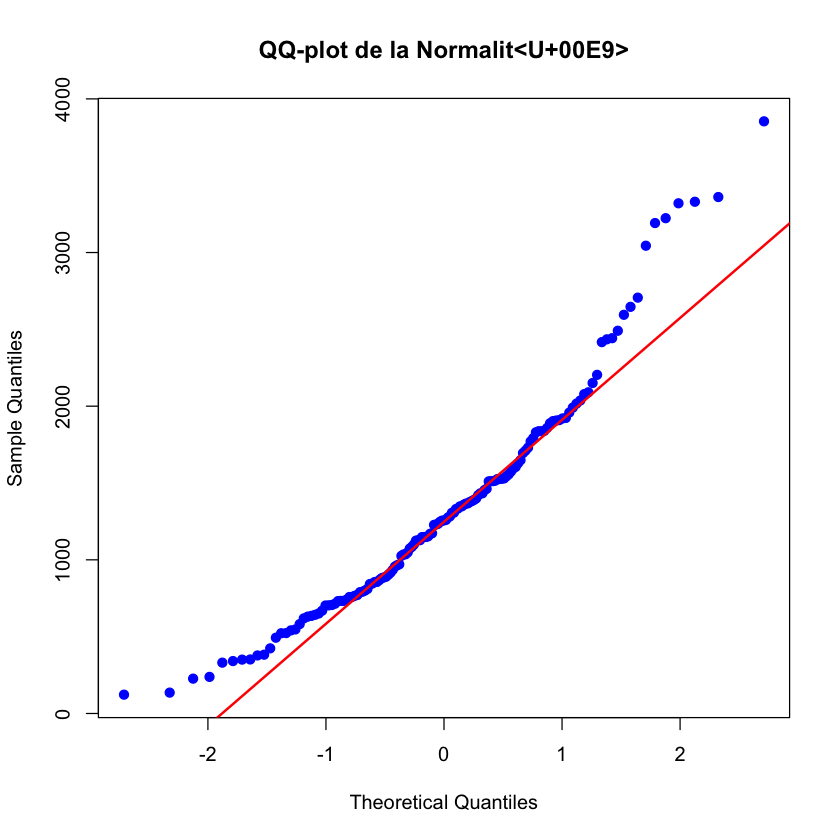

In [70]:
qqnorm(data$Debit, main = "QQ-plot de la Normalité", pch = 19, col = "blue")
qqline(data$Debit, col = "red", lwd = 2)  # Ajouter la ligne de référence
shapiro.test(data$Debit) # On rejette le test de normalité
nortest::ad.test(data$Debit) # On rejette le test de normalité

In [71]:
# Paramètres de la loi de Gumbel
mode <- 1013
echelle <- 558

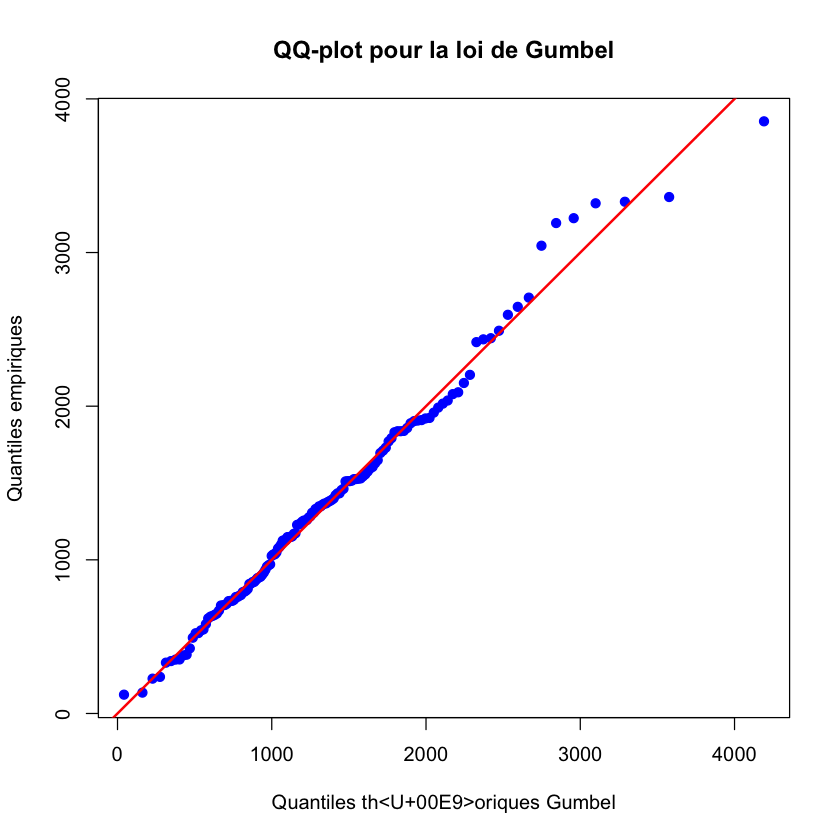

In [72]:
# Trier les données empiriques
data_empirique <- sort(data$Debit)

# Générer des quantiles théoriques de la loi de Gumbel
n <- length(data_empirique)
quantiles_theoriques <- qgumbel(ppoints(n), loc = mode, scale = echelle)

# QQ-plot
qqplot(quantiles_theoriques, data_empirique, main = "QQ-plot pour la loi de Gumbel",
       xlab = "Quantiles théoriques Gumbel", ylab = "Quantiles empiriques",
       pch = 19, col = "blue")

# Ajouter la ligne de référence
abline(0, 1, col = "red", lwd = 2)

#### Modélisation des résidus

In [73]:
# Extraire les résidus
residus <- residuals(model_glm)

# Calculer la moyenne et l'écart-type
moyenne_res <- mean(residus)
ecart_type_res <- sd(residus)


	Shapiro-Wilk normality test

data:  residus
W = 0.98382, p-value = 0.1492



	Anderson-Darling normality test

data:  residus
A = 0.62467, p-value = 0.1015


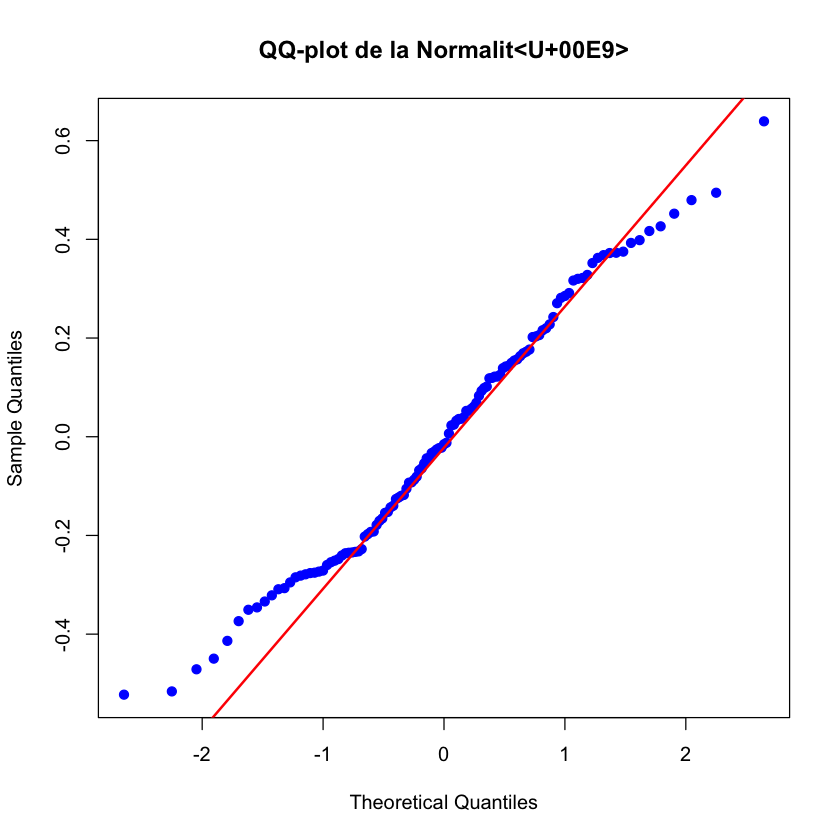

In [74]:
qqnorm(residus, main = "QQ-plot de la Normalité", pch = 19, col = "blue")
qqline(residus, col = "red", lwd = 2)  # Ajouter la ligne de référence
shapiro.test(residus) # On rejette le test de normalité
nortest::ad.test(residus)

#### Estimation de la hauteur de la digue

##### Estimation conservatrice

In [75]:
#Paramètres Zv
mu_Zv <- 50
min_Zv <- 49
max_Zv <- 51

#Côte de la berge
Zb <- 55.5

In [76]:
# Calcul de la valeur seuil pour 99.99% des données des résidus
quantile <- mode - echelle*log(-log(0.9999)) # = 6152
hauteur_eau <- predict(model_glm,data.frame("Debit" = quantile))

# Calculer le quantile 99.99%
quantile_95_norm <- moyenne_res + qnorm(0.9999) * ecart_type_res

hauteur_eau <- hauteur_eau + quantile_95_norm
cat("La hauteur d'eau auquel il faut se protéger est de ", hauteur_eau,"m.","\n")

# Calcul de la hauteur de surverse qui correspond à la hauteur de la digue
Zc <- hauteur_eau + max_Zv 
hauteur_digue <- Zc - Zb

cat("Il faut une hauteur de digue de ", hauteur_digue, "m pour le modèle conservateur.")

La hauteur d'eau auquel il faut se prot<U+00E9>ger est de  10.53811 m. 
Il faut une hauteur de digue de  6.038108 m pour le mod<U+00E8>le conservateur.

##### Estimation modérée

In [77]:
# Calcul de la valeur seuil pour 99.99% des données des résidus
quantile <- mode - echelle*log(-log(0.9999)) # = 6152
hauteur_eau <- predict(model_glm,data.frame("Debit" = quantile))

cat("La hauteur d'eau auquel il faut se protéger est de ", hauteur_eau,"m.","\n")

# Calcul de la hauteur de surverse qui correspond à la hauteur de la digue
Zc <- hauteur_eau + mu_Zv 
hauteur_digue <- Zc - Zb

cat("Il faut une hauteur de digue de ", hauteur_digue, "m pour le modèle modéré.")

La hauteur d'eau auquel il faut se prot<U+00E9>ger est de  9.607105 m. 
Il faut une hauteur de digue de  4.107105 m pour le mod<U+00E8>le mod<U+00E9>r<U+00E9>.

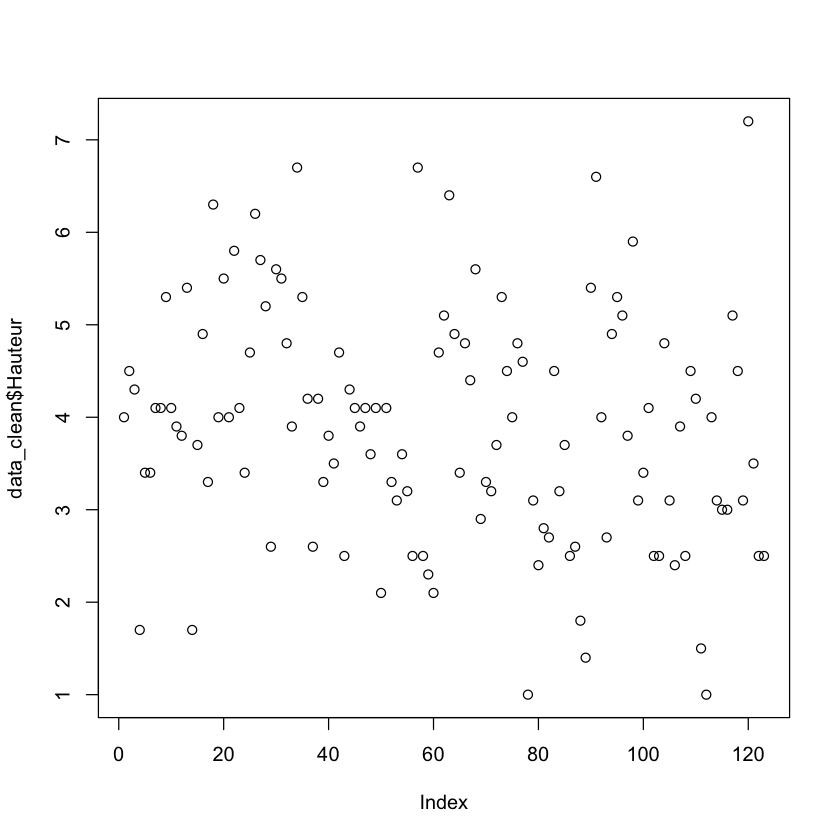

In [78]:
plot(data_clean$Hauteur)

In [79]:
listevar <- list()
j <- 1
# calculer écart de variance toutes les 10 valeurs
for (i in seq(1,nrow(data_clean),by=25)){
    listevar[j] <- var(data_clean[i:(i+25),"Hauteur"])
    j <- j+1
}

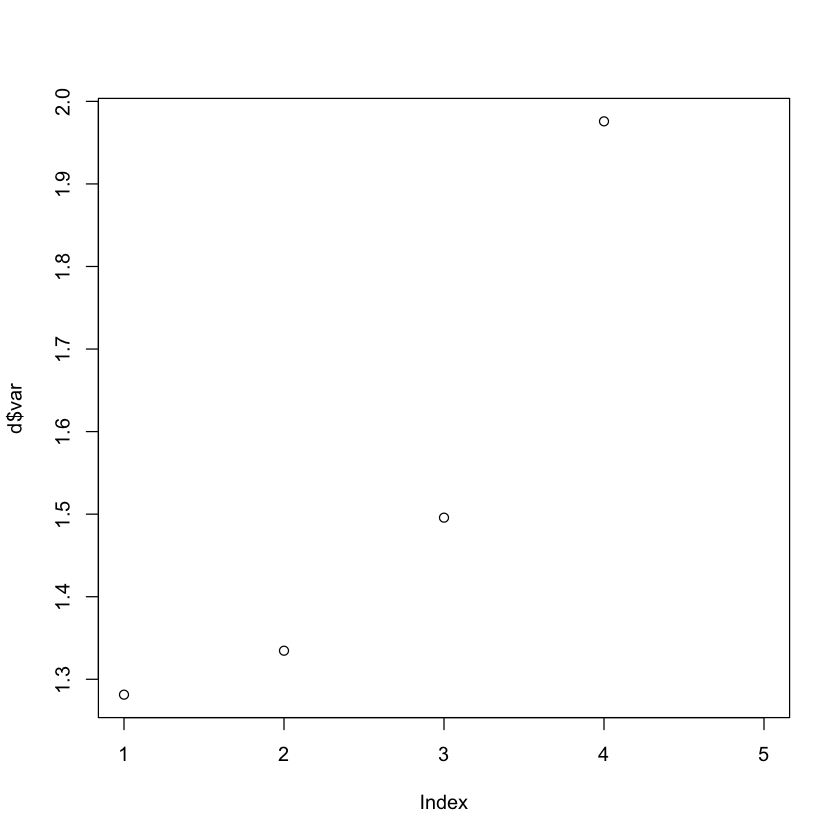

In [80]:
d <- do.call(rbind.data.frame, listevar)
colnames(d) <- c("var")
plot(d$var)

On prendre rajouter une marge de sécurité qui comprend les changements climatiques, ce changement de variance et tout événement imprédictible

##### Estimation simulation Monte Carlo

In [81]:
set.seed(123)
#Nombre d'échantillons
n <- 1000000


#Paramètres déterministes
Zb <- 55.5

#Paramètres epsilon
mu <- mean(residus)
sigma <- sd(residus)

#Paramètres Q
loc_Q <- 1013
scale_Q <- 558

#Paramètres Zv
mu_Zv <- 50
min_Zv <- 49
max_Zv <- 51

# Simulations des variables aléatoires
Zv <- rtriangle(n, a = min_Zv, b = max_Zv, c = mu_Zv)
Q <- rgumbel(n, loc = loc_Q, scale = scale_Q)
epsilon <- rnorm(n, mu, sigma)
# On retire des débits si les débits sont négatifs
while (any(Q < 0)) {
Q[Q < 0] <- rgumbel(sum(Q < 0), loc = loc_Q, scale = scale_Q)
}
f_Q <- model_glm$coefficients[1] + sqrt(Q)*model_glm$coefficients[2]

# Calcul de la hauteur de la digue
h_d <- Zv + f_Q + epsilon - Zb

In [82]:
quantile(h_d, 0.999999)

99.9999% 
5.985278

In [83]:
quantile_empirique <- quantile(h_d, probs = 0.99, type = 7)
print(quantile_empirique)

     99% 
1.829435 


In [84]:
sum(h_d > 0)/length(h_d)

[1] 0.123901

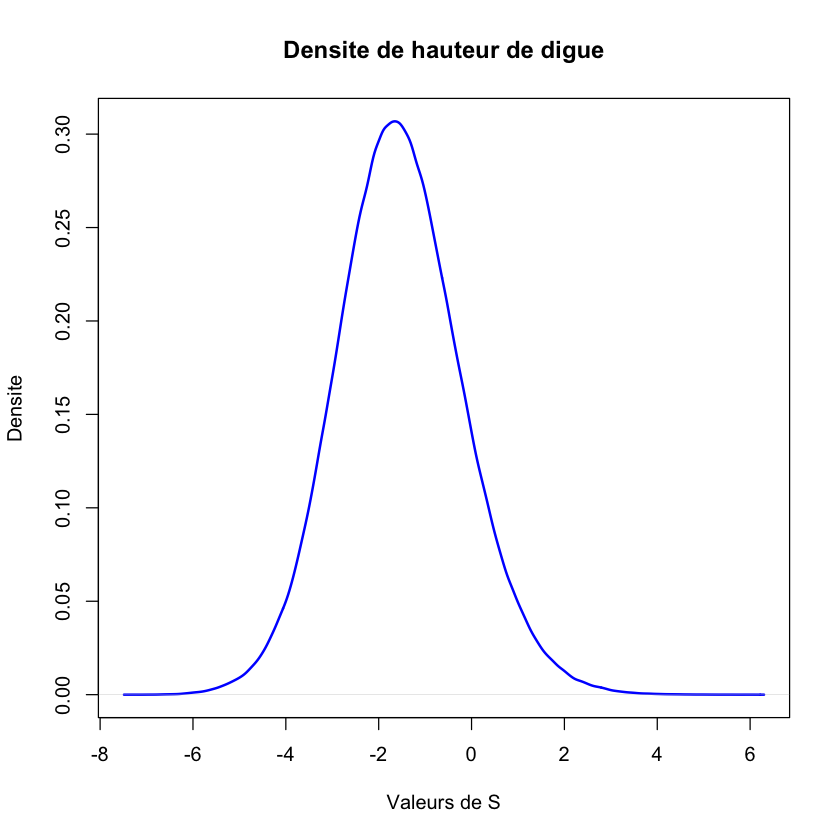

In [85]:
density_hd = density(h_d)
plot(density_hd, col = "blue", lwd = 2, main = "Densite de hauteur de digue", xlab = "Valeurs de S", ylab = "Densite")

#### Perspectives

On pourrait rajouter une marge de sécurité dans les modèles car il y a des causes comme le changement climatique par exemple qui peuvent influencer la hauteur de l'eau. En l'occurence, le changement climatique fait augmenter le niveau d'eau. 

## Modèle hydraulique

#### Simulation des données

Nous utilisons la méthode de Monte Carlo Simulation pour déterminer la distribution de la surverse (S) en fonction des variables aléatoires connues. \
• Zm ~ tri(49, 51, 50) et Zy ~ tri(54, 56, 55): désignent la cote du fond du cours d'eau (en m NGF) respectivement en amont et en aval du tronçon.\
• Ks ~ N(30, 7.5): désigne le coefficient de frottement du lit du cours d'eau. \
• Q ~ Gumbel(1013, 558): désigne le débit maximal du cours d'eau (en m/s) 

In [86]:
set.seed(123)
n <- 1000000
Zm <- rtriangle(n, a = 54, b = 56, c = 55)
Zv <- rtriangle(n, a = 49, b = 51, c = 50)

# Paramètres : position (μ), échelle (β)
loc <- 1013
scale <- 558
Q <- rgumbel(n, loc = loc, scale = scale)
while (any(Q < 0)) {
  Q[Q < 0] <- rgumbel(sum(Q < 0), loc = loc, scale = scale)
}
# Paramètres : moyenne (μ), écart-type (σ)
mu <- 30
sigma <- 7.5
Ks = rnorm(n, mean = mu, sd = sigma)
while (any(Ks < 0)) {
  Ks[Ks < 0] <- rnorm(sum(Ks < 0), mean = mu, sd = sigma)
}

L = 5000
B = 300
Zb = 55.5

H <- (Q/(Ks*sqrt((Zm-Zv)/L)*B))**(3/5)

S = Zv + H - Zb

#### Modélisation des données simulées

On vérifie la densité des variables similées et remarqu'elles suivent bien les lois hypothétiques.

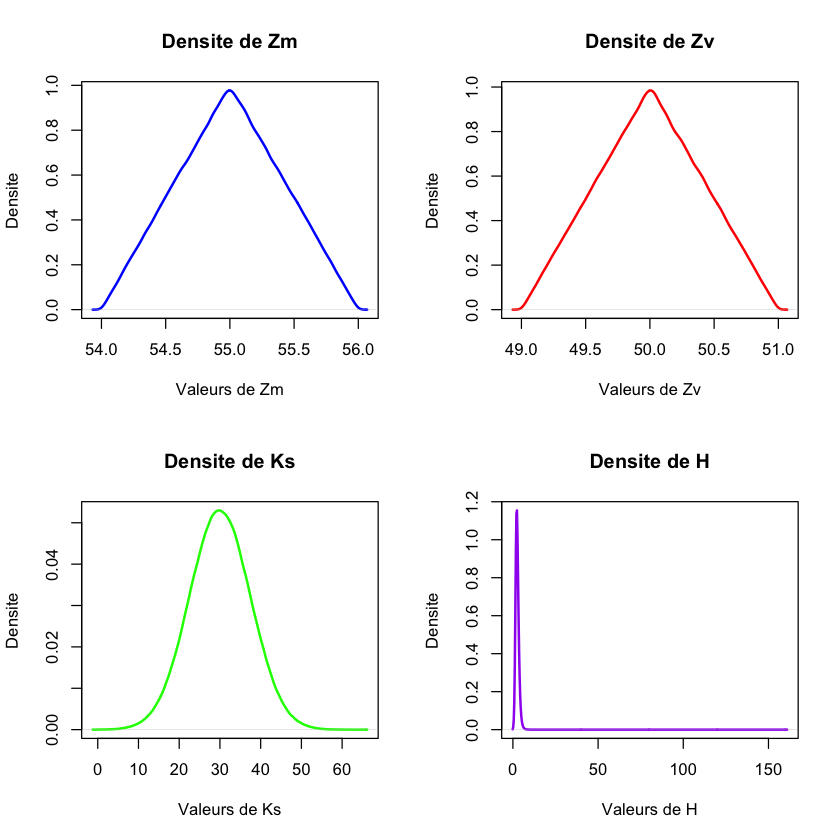

In [87]:
density_Zm <- density(Zm)
density_Zv <- density(Zv)
density_Ks <- density(Ks)
density_H <- density(H)


par(mfrow = c(2,2))

# Tracer les densités
plot(density_Zm, col = "blue", lwd = 2, main = "Densite de Zm", xlab = "Valeurs de Zm", ylab = "Densite") 
plot(density_Zv, col = "red", lwd = 2, main = "Densite de Zv", xlab = "Valeurs de Zv", ylab = "Densite") 
plot(density_Ks, col = "green", lwd = 2, main = "Densite de Ks", xlab = "Valeurs de Ks", ylab = "Densite") 
plot(density_H, col = "purple", lwd = 2, main = "Densite de H", xlab = "Valeurs de H", ylab = "Densite") 

# Réinitialiser l'affichage à 1 seul graphique après exécution
par(mfrow = c(1, 1))



La loi de la surverse (S) est en première vue une loi de la valeur extrême.

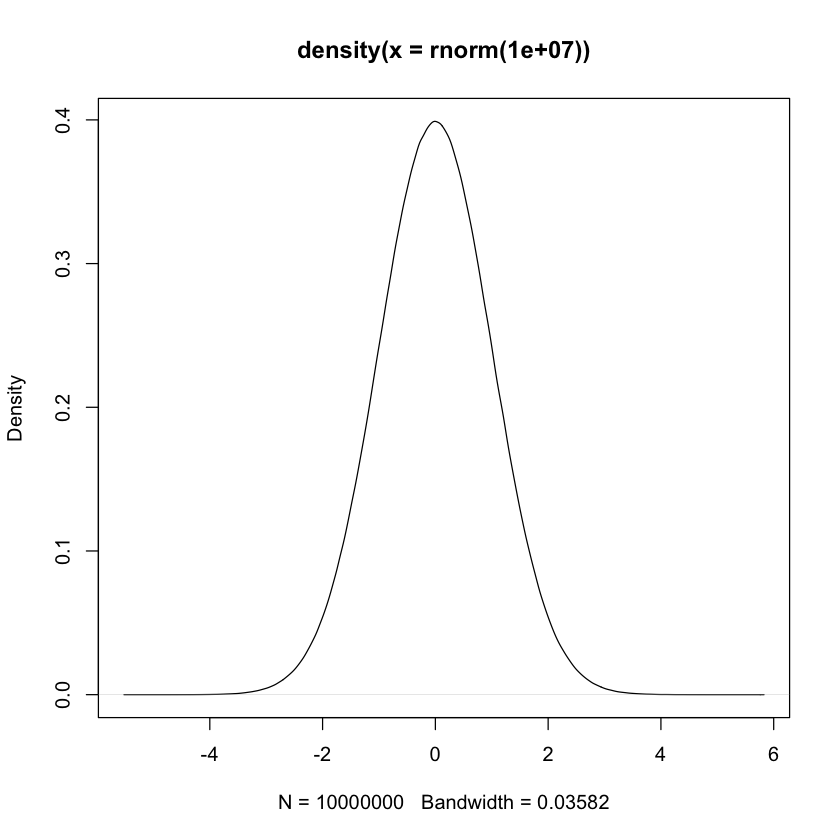

In [89]:
plot(density(rnorm(10000000)))

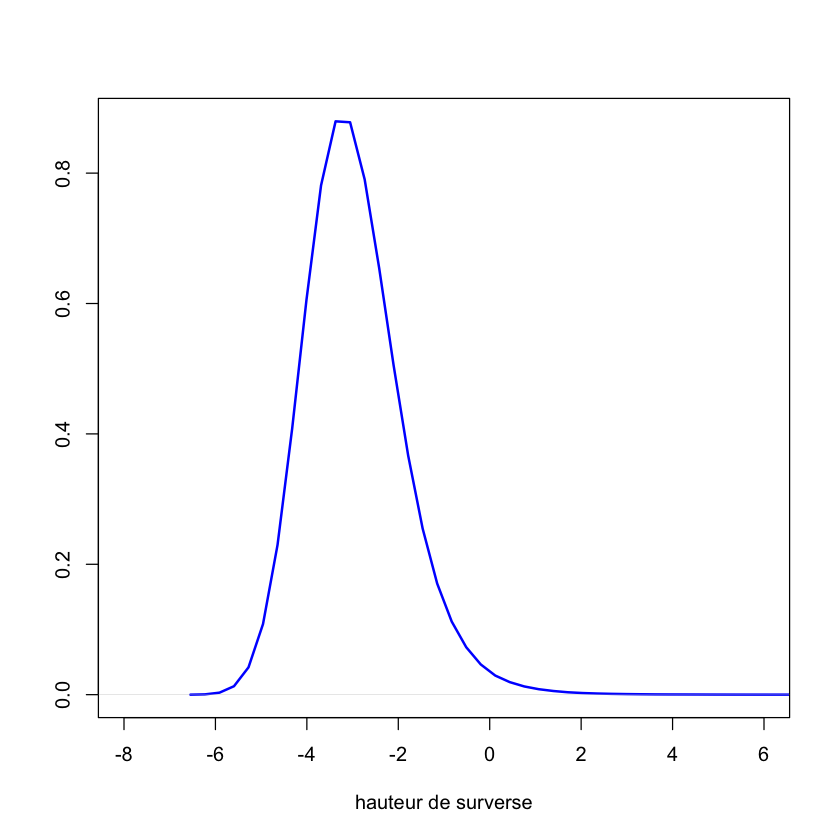

In [90]:
density_S = density(S)
plot(density_S, col = "blue", lwd = 2, xlab = "hauteur de surverse", ylab="", main="", xlim = c(-8,6)) 

En construsant un quantile de 99%, nous obtenons une hauteur de surverse à 0,12 mètres qui est raisonnable.

In [91]:
quantile(S, probs = 0.9999, na.rm = TRUE)
quantile(S, probs = 0.99, na.rm = TRUE)

99.99% 
7.508409

99% 
0.1218514

#### Comparaison la prédiction du modèle historique et modèle hydraulique

In [92]:
# iter = seq(from = 0.95,to = 0.9999, by = (0.9999-0.95)/20)
iter = c(0.95, 0.97, 0.99, 0.999, 0.9999, 0.99999, 0.999999)
conservatrice = rep(0, length(iter))
moderee = rep(0, length(iter))
hydraulique = rep(0, length(iter))
monte <- rep(0, length(iter))


for (i in 1:length(iter)){

    # Calcul de la valeur seuil pour 99.99% des données des résidus
    quantile <- mode - echelle*log(-log(iter[i])) # = 6152
    hauteur_eau <- predict(model_glm,data.frame("Debit" = quantile))

    # Calculer le quantile 99.99%
    quantile_95_norm <- moyenne_res + qnorm(iter[i]) * ecart_type_res

    hauteur_eau <- hauteur_eau + quantile_95_norm

    # Calcul de la hauteur de surverse qui correspond à la hauteur de la digue
    Zc <- hauteur_eau + max_Zv 
    hauteur_digue <- Zc - Zb
    conservatrice[i] = hauteur_digue
    

    # Calcul de la hauteur de surverse qui correspond à la hauteur de la digue
    Zc_mo <- hauteur_eau + mu_Zv 
    hauteur_digue_mo <- Zc_mo - Zb
    moderee[i] = hauteur_digue_mo

    hydraulique[i] = quantile(S, probs = iter[i], na.rm = TRUE)

    monte[i] <- quantile(h_d, probs=iter[i])

}


Étant donné que la densité de la surverse a une queue lourde, la prédiction est beaucoup plus sensible aux quantiles élevés. En revanche, les prédictions des modèles historiques sont linéaires. À partir du quantile de 99,99\%, la surverse du modèle hydraulique dépasse celle des modèles historiques et croît exponentiellement.

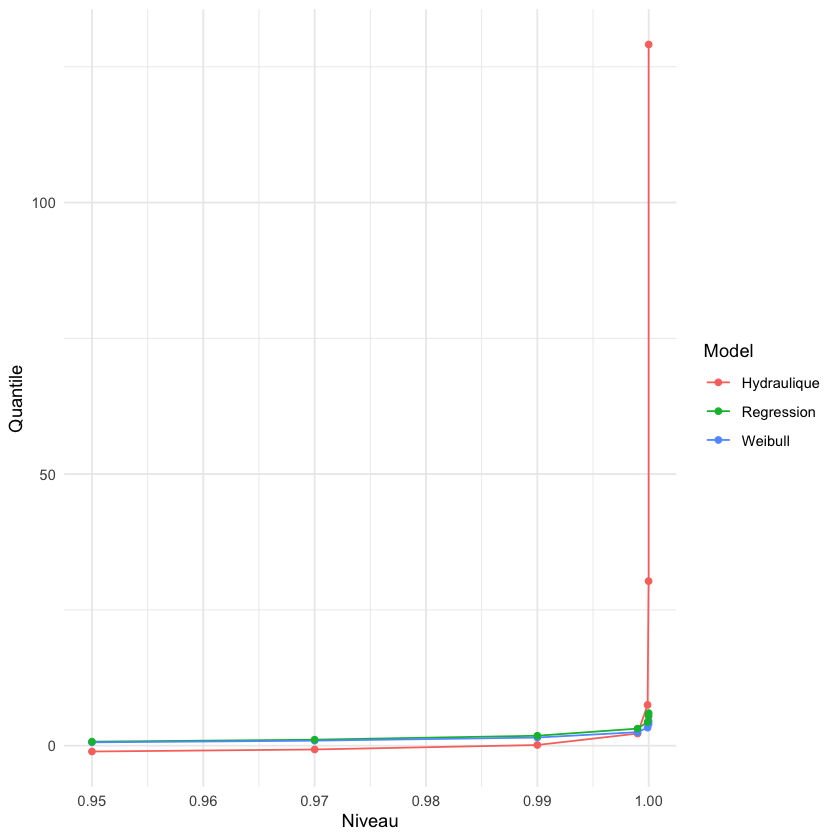

In [93]:
# Create a data frame for ggplot
data <- data.frame(
  Quantiles = c(0.95, 0.97, 0.99, 0.999, 0.9999, 0.99999, 0.999999),
  Hydraulique = hydraulique,
  Weibull = c(0.611446121683881, 0.919938776265055, 1.49624723509279, 2.48714648153599, 3.31212175122432, 3.97261539591549, 4.49808392811493),
  Regression = monte
)

# Reshape the data for ggplot
library(tidyr)
data_long <- data %>%
  gather(key = "Model", value = "Value", Hydraulique, Weibull, Regression)

# Plot using ggplot2
ggplot(data_long, aes(x = Quantiles, y = Value, color = Model)) +
  geom_line() +  # To plot lines
  geom_point() + # To add points
  labs(x = "Niveau", y = "Quantile") +
  theme_minimal()


## Modèle économique

Construction des fonctions pour intégrer l'aspect économique

In [115]:
couts_table <- function(vec, table, column_x, column_cout) {
    return (sapply(vec, function(x) {
        ind <- findInterval(x, table[[column_x]])
        if (ind==0) {
            return(0)
        }
        else if (ind == length(table[[column_x]])) {
            return (table[[column_cout]][ind])
        }
        else {
            return (table[[column_cout]][ind] + (table[[column_cout]][ind+1] - table[[column_cout]][ind]) * (x - table[[column_x]][ind]) / (table[[column_x]][ind+1] - table[[column_x]][ind]))
        }
    }))
}

monte_carlo_eco <- function(n, T, h_d, table_investissement, table_dommages, random_seed=42) {

    set.seed(random_seed)

    # Initialisation du vecteur des coûts
    couts <- rep(0, length(h_d))

    # Calcul des coûts d'investissement pour chaque hauteur de digue
    C_i <- couts_table(h_d, table_investissement, "Hauteur", "Cout_digue")

    # Paramètres déterministes
    L <- 5000
    B <- 300
    Zb <- 55.5

    # Paramètres Q
    loc_Q <- 1013
    scale_Q <- 558

    # Paramètres Zm et Zv
    mu_Zm <- 55
    min_Zm <- 54
    max_Zm <- 56
    mu_Zv <- 50
    min_Zv <- 49
    max_Zv <- 51

    # Paramètres Ks
    mu_Ks <- 30
    sigma_Ks <- 7.5

    for (i in 1:n) {
        # Simulations des variables aléatoires
        Zm <- rtriangle(T, a = min_Zm, b = max_Zm, c = mu_Zm)
        Zv <- rtriangle(T, a = min_Zv, b = max_Zv, c = mu_Zv)
        Q <- rgumbel(T, loc = loc_Q, scale = scale_Q)
        # On tire de nouvelles valeurs pour les débits négatifs
        while (any(Q < 0)) {
            Q[Q < 0] <- rgumbel(sum(Q < 0), loc = loc_Q, scale = scale_Q)
        }
        # On tire de nouvelles valeurs les coefficients de Strickler négatifs
        Ks <- rnorm(T, mean = mu_Ks, sd = sigma_Ks)
        while (any(Ks < 0)) {
            Ks[Ks < 0] <- rnorm(sum(Ks < 0), mean = mu_Ks, sd = sigma_Ks)
        }

        # Calcul des hauteurs d'eau
        H <- (Q/(Ks*sqrt((Zm-Zv)/L)*B))**(3/5)

        # Calcul cumulé du coûts des dommages
        couts <- couts + sapply(h_d, function(h){
            C_s <- sum(couts_table(Zv + H - Zb - h, table_dommages, "Surverse", "Dommages_site"))
            C_g <- sum(couts_table(Zv + H - Zb - h, table_dommages, "Surverse", "Dommages_digue")) * C_i[h_d==h]
            C_s + C_g
        })
    }

    # Calcul de la moyenne emprique des coûts annualisés
    couts <- couts/(n*T) + (1+0.01*T)*C_i/T # où 0.01*T*C_i est le coût de maintenance annuel

    return (couts)
}

In [116]:
couts_1 <- read_excel(path="Couts.xlsx", sheet="Cout_investissement")
couts_2 <- read_excel(path="Couts.xlsx", sheet="Cout_dommages")

In [123]:
couts_1

Hauteur,Cout_lineaire,Longueur,Cout_digue
<dbl>,<dbl>,<dbl>,<dbl>
0.0,0.0000,0.000,0
0.1,100.0000,1000.000,100000
0.5,150.0000,1500.000,225000
1.0,424.2641,2436.757,1033829
2.0,1200.0000,3958.524,4750228
3.0,2204.5408,5000.000,11022704
4.0,3394.1125,5000.000,16970563
5.0,4338.3766,5000.000,21691883
6.0,5301.8401,5000.000,26509200


In [124]:
couts_2

Surverse,Dommages_site,Dommages_digue
<dbl>,<dbl>,<dbl>
-0.1,0.0e+00,0.0
0.0,0.0e+00,0.1
0.5,1.5e+08,0.5
1.0,1.5e+09,1.0
1.5,2.0e+09,1.0
2.0,2.0e+09,1.0


Simuler la hauteur de la surverse avec le contraint d'économie

In [119]:
simul_2 <- monte_carlo_eco(1e6, 30, couts_1$Hauteur, couts_1, couts_2, random_seed=123)

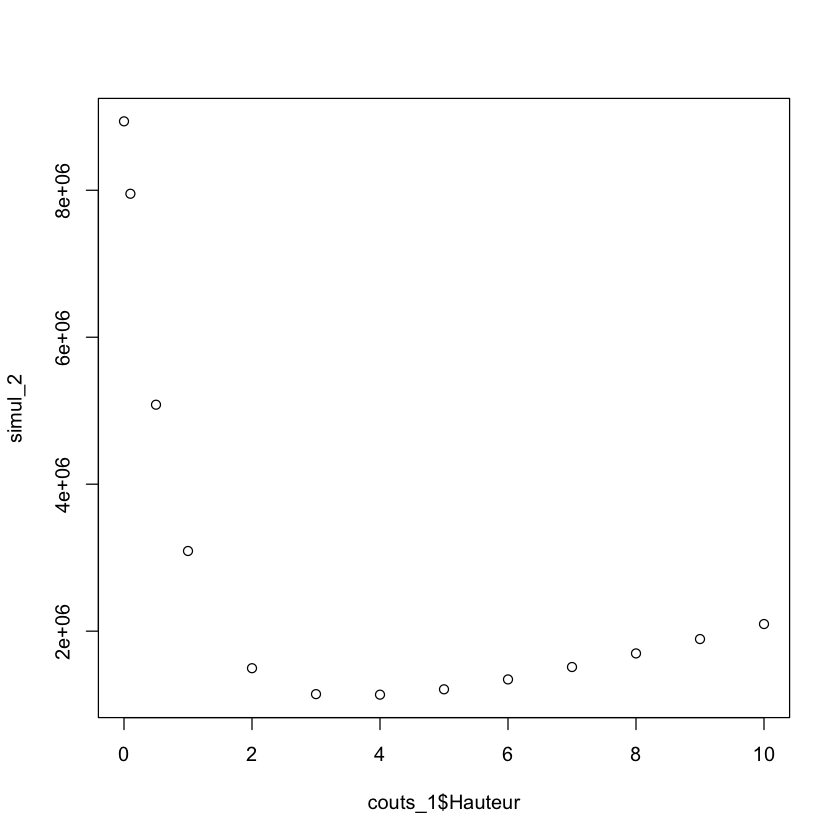

In [122]:
plot(couts_1$Hauteur, simul_2)